In [1]:
from modules.models import KPPinn, create_dense_model
from modules.data import simulate_KP
from modules.plots import plot_KdV_model, plot_training_loss
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2023-07-27 11:49:30.209273: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
k=6
c= 3.23
phi = 0


def phi_function(txy):
    
    offset =  +12
    ksi = txy[:, 1:2]-c*txy[:,0:1]+offset

    u = c / (2*tf.cosh(np.sqrt(c)*(ksi/2))**2)+phi
    return u
    

def boundary_function(txy):
    return phi*tf.ones_like(txy[:, 1:2])

# x_start = 0
# length = 8*np.pi
x_start =  -50. #-10
length = 50.#10
time =  10

In [3]:
(txy_eqn, u_eqn), (txy_init, u_init), (txy_boundary, u_boundary) = simulate_KP(1000, phi_function, boundary_function, time, x_start, length, x_start, length, random_seed = 42, dtype=tf.float32)

2023-07-27 11:49:52.378741: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


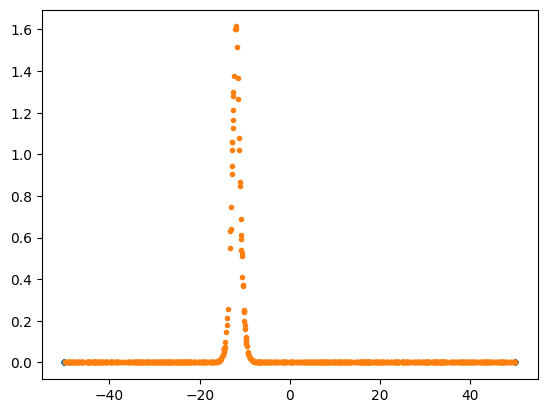

In [4]:
plt.plot(txy_boundary[:,1:2],u_boundary,'.')

plt.plot( txy_init[:,1:2],phi_function(txy_init),'.')

inputs = [txy_eqn, txy_init, txy_boundary]
outputs = [phi_function(txy_eqn), u_eqn, u_init, u_boundary]


In [5]:
backbone = create_dense_model([128, 128, 128], activation='tanh', initializer='glorot_normal', \
    n_inputs=3, n_outputs=1)
pinn = KPPinn(backbone, k=6.)
scheduler = tf.keras.optimizers.schedules.ExponentialDecay(1e-3, decay_steps=500, decay_rate=0.85)
optimizer = tf.keras.optimizers.Adam(learning_rate=scheduler, clipnorm=1.)
pinn.compile(optimizer=optimizer)

In [6]:
history = pinn.fit_custom(inputs, outputs, epochs = 20000, print_every = 500)

Epoch 0, Loss Residual: 0.0004, Loss Initial: 0.1976, Loss Boundary: 0.4982, MAE: 0.4041
Epoch 500, Loss Residual: 0.0002, Loss Initial: 0.0197, Loss Boundary: 0.0000, MAE: 0.0799
Epoch 1000, Loss Residual: 0.0002, Loss Initial: 0.0136, Loss Boundary: 0.0001, MAE: 0.1377
Epoch 1500, Loss Residual: 0.0002, Loss Initial: 0.0045, Loss Boundary: 0.0000, MAE: 0.1879
Epoch 2000, Loss Residual: 0.0003, Loss Initial: 0.0024, Loss Boundary: 0.0000, MAE: 0.1822
Epoch 2500, Loss Residual: 0.0003, Loss Initial: 0.0017, Loss Boundary: 0.0000, MAE: 0.1861
Epoch 3000, Loss Residual: 0.0001, Loss Initial: 0.0011, Loss Boundary: 0.0000, MAE: 0.1871
Epoch 3500, Loss Residual: 0.0001, Loss Initial: 0.0008, Loss Boundary: 0.0000, MAE: 0.1881
Epoch 4000, Loss Residual: 0.0000, Loss Initial: 0.0005, Loss Boundary: 0.0000, MAE: 0.1849
Epoch 4500, Loss Residual: 0.0000, Loss Initial: 0.0004, Loss Boundary: 0.0000, MAE: 0.1804
Epoch 5000, Loss Residual: 0.0000, Loss Initial: 0.0003, Loss Boundary: 0.0000, MAE:

In [9]:
# history = pinn.fit(inputs, outputs, epochs= 20000, batch_size=tx_samples.shape[0], verbose=0)
# history = pinn.fit_custom(inputs, outputs, epochs=20000, print_every = 1000)

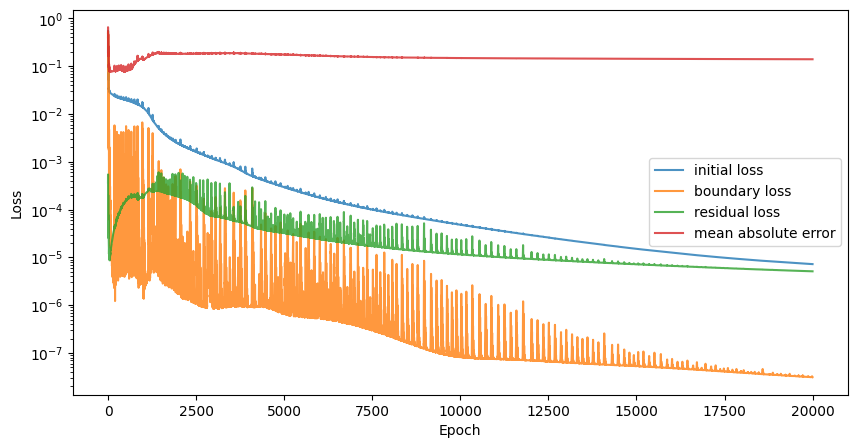

In [7]:
plot_training_loss(history, y_scale='log')

1/1 [==============================] - 0s 34ms/step


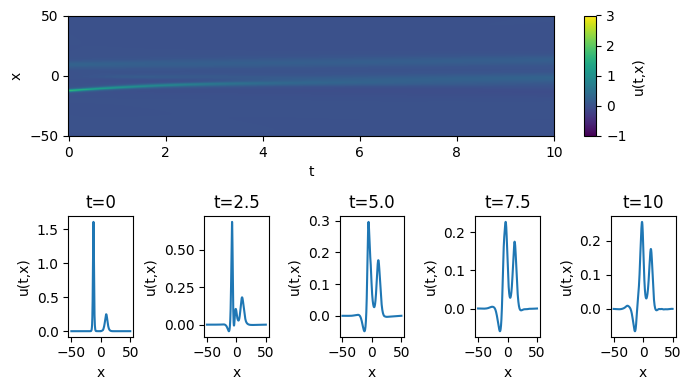

In [157]:
plot_KdV_model(pinn.backbone, x_start,length, time, -1, 3, save_path = None, show=True) 

In [144]:



backbone2 = create_dense_model([64, 64], activation='tanh', initializer='glorot_normal', \
n_inputs=2, n_outputs=1)
layer1 = pinn.backbone.get_layer(index=1) 
layer_new = backbone2.get_layer(index=1) 
layer2 = pinn.backbone.get_layer(index=2) 
layer_new2 = backbone2.get_layer(index=2) 
tx_weights1 = layer1.get_weights()[0] # first axis used for t and x, e.g. [:1,:]
biases = layer1.get_weights()[1]
tx_weights2 = layer2.get_weights()[0] 
biases2 = layer2.get_weights()[1]
layer_new.set_weights([tx_weights1, biases])
layer_new2.set_weights([tx_weights2, biases2])
# penal = 1-0.25*ii
pinn2 = KdVPinn(backbone2, k=6.)
scheduler = tf.keras.optimizers.schedules.ExponentialDecay(1e-3, decay_steps=500, decay_rate=0.82)
optimizer = tf.keras.optimizers.Adam(learning_rate=scheduler)
pinn2.compile(optimizer=optimizer)
history2 = pinn2.fit_custom(inputs, outputs, epochs=10000, print_every= 1000) # input and output was changed according to two-soliton



Epoch 0, Loss Residual: 0.0232, Loss Initial: 0.7920, Loss Boundary: 0.9517, MAE: 0.7438
Epoch 1000, Loss Residual: 0.0003, Loss Initial: 0.0035, Loss Boundary: 0.0000, MAE: 0.0660
Epoch 2000, Loss Residual: 0.0001, Loss Initial: 0.0009, Loss Boundary: 0.0000, MAE: 0.0562
Epoch 3000, Loss Residual: 0.0001, Loss Initial: 0.0003, Loss Boundary: 0.0000, MAE: 0.0541
Epoch 4000, Loss Residual: 0.0001, Loss Initial: 0.0001, Loss Boundary: 0.0000, MAE: 0.0524
Epoch 5000, Loss Residual: 0.0000, Loss Initial: 0.0001, Loss Boundary: 0.0000, MAE: 0.0514
Epoch 6000, Loss Residual: 0.0000, Loss Initial: 0.0000, Loss Boundary: 0.0000, MAE: 0.0505
Epoch 7000, Loss Residual: 0.0000, Loss Initial: 0.0000, Loss Boundary: 0.0000, MAE: 0.0497
Epoch 8000, Loss Residual: 0.0000, Loss Initial: 0.0000, Loss Boundary: 0.0000, MAE: 0.0491
Epoch 9000, Loss Residual: 0.0000, Loss Initial: 0.0000, Loss Boundary: 0.0000, MAE: 0.0485


In [158]:
from matplotlib.gridspec import GridSpec
def plot_snapshots(timeList,num_test_samples = 1000):
    x_flat = np.linspace(x_start, length, num_test_samples)
    y_flat = np.linspace(x_start, length, num_test_samples)
    t_flat = np.linspace(0, time, num_test_samples)
    x_flat = tf.convert_to_tensor(x_flat)
    y_flat = tf.convert_to_tensor(y_flat)
    t_flat = tf.convert_to_tensor(t_flat)
    # t_, x_ = tf.meshgrid(t_flat, x_flat)
    # tx = tf.concat((tf.reshape(t_, (-1, 1)), tf.reshape(x_, (-1, 1))), axis=1)
    # solution = phi_function_PBC(tx,num_test_samples ,num_test_samples)
    # solution = tf.reshape(solution, x_.shape)
    t, x, y = np.meshgrid(t_flat, x_flat, y_flat)
    txy = np.stack([t.flatten(), x.flatten(), y.flatten*()], axis=-1) #
    # u = pinn.backbone.predict(txy, batch_size=num_test_samples)
    # u = u.reshape(t.shape)

    # plot u(t,x) distribution as a color-map
    fig = plt.figure(figsize=(7,4))
    gs = GridSpec(2, 5)
    plt.subplot(gs[0, :])
    plt.pcolormesh(t, x, u)
    plt.xlabel('t')
    plt.ylabel('x')
    cbar = plt.colorbar(pad=0.05, aspect=10)
    cbar.set_label('u(t,x)')
    cbar.mappable.set_clim(-1, 2)
    dt=time/(num_test_samples-1)
    t_cross_sections = timeList
    for i, t_cs in enumerate(t_cross_sections):
        txy = np.stack([np.full(t_flat.shape, t_cs), x_flat, y_flat], axis=-1)  
        fig = plt.figure(figsize=(7,4))
        gs = GridSpec(2, 5)
        plt.subplot(gs[0, :])
        plt.pcolormesh(t, x, u)
        plt.xlabel('t')
        plt.ylabel('x')
        cbar = plt.colorbar(pad=0.05, aspect=10)
        cbar.set_label('u(t,x)')
        cbar.mappable.set_clim(-1, 2)
    #     tx = np.stack([np.full(t_flat.shape, t_cs), x_flat], axis=-1)
    #     print(tx.shape)
    #     u = pinn.backbone.predict(tx, batch_size=num_test_samples)
    #     plt.plot(x_flat, u, label = 'prediction at time {}'.format(t_cs))
    #     print(int(t_cs/dt+1))
    #     # plt.plot(x_flat, solution[:,int(t_cs/dt)], label = 'exact')
    #     plt.plot(x_flat, phi_function(tx), '.',label = 'exact at time {}'.format(t_cs))
    #     plt.legend()
    #     plt.title('t={}'.format(np.round(t_cs,2)))
    #     plt.xlabel('x')
    #     plt.ylabel('u(t,x)')
    return

(1000, 2)
1/1 [==============================] - 0s 83ms/step
1000


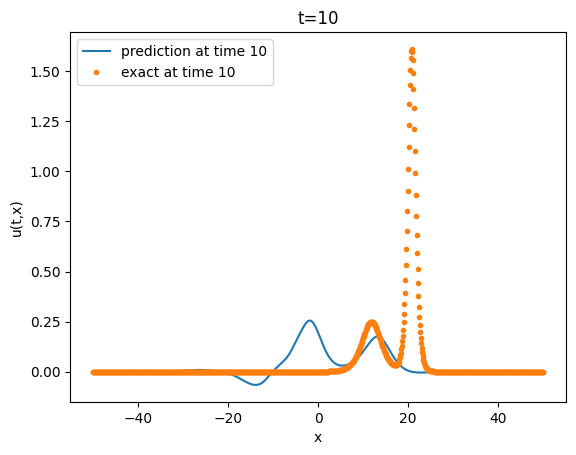

In [171]:
plot_snapshots([10])